# Phishing URL Detection with Machine Learning

This notebook demonstrates the process of training a machine learning model to detect phishing URLs using static analysis of URL features. We'll extract various features from URLs, perform feature selection, train a LinearSVC model, and evaluate its performance.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os
from scipy.sparse import hstack
from joblib import dump
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

from feature_extractor import URLFeatureExtractor
from feature_selection import FeatureSelector

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## 2. Set Up Directories

In [2]:
# --- Create directories ---
training_report_dir = 'training_report'
models_dir = 'models'

for directory in [training_report_dir, models_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

Created directory: training_report
Created directory: models


## 3. Load Dataset

We'll load the balanced dataset of URLs with their classifications (phishing or legitimate).

In [3]:
print("[+] Loading dataset...")
df = pd.read_csv('data/balanced_urls.csv')  # Must contain 'url' and 'result' columns
df.dropna(subset=['url', 'result'], inplace=True)

X_raw = df['url'].astype(str)
y = df['result'].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Number of phishing URLs (1): {sum(y == 1)}")
print(f"Number of legitimate URLs (0): {sum(y == 0)}")

[+] Loading dataset...
Dataset shape: (88024, 3)
Number of phishing URLs (1): 69714
Number of legitimate URLs (0): 18310


## 4. Feature Extraction

We'll extract static features from the URLs using our custom feature extractor.

In [4]:
print("[+] Extracting features (this may take a while for large datasets)...")
custom_extractor = URLFeatureExtractor()

# Define all feature names for reference
all_feature_names = [
    'url_length', 'dot_count', 'hyphen_count', 'ip_address',
    'keyword_count', 'uses_https', 'query_param_count',
    'subdomain_count', 'has_at_symbol', 'has_suspicious_ext',
    'has_port', 'path_length', 'special_char_count', 'digit_count',
    'digit_letter_ratio', 'is_shortened', 'path_depth', 
    'avg_word_length_in_path', 'domain_length', 'subdomain_to_domain_ratio',
    'contains_brand_name', 'multiple_tlds', 'has_https_in_path',
    'host_contains_digits', 'entropy', 'is_domain_ip', 'domain_only_length',
    'keyword_in_domain', 'keyword_in_path', 'keyword_in_query',
    # NLP-based features
    'meaningful_words_ratio', 'word_to_length_ratio', 'is_domain_in_dictionary',
    'is_common_tld', 'domain_entropy', 'path_entropy', 'max_consecutive_consonants',
    'has_punycode', 'lexical_diversity',
    # Advanced features
    'path_semantic_score', 'url_structure_pattern', 'is_restricted_tld',
    'has_official_terms', 'has_media_terms', 'domain_age_influence', 
    'readability_score', 'is_popular_domain'
]

# Extract features
X_custom = custom_extractor.fit_transform(X_raw)

# Convert to DataFrame for better feature handling
X_df = pd.DataFrame(X_custom, columns=all_feature_names[:X_custom.shape[1]])
print(f"[+] Extracted {X_df.shape[1]} features from {X_df.shape[0]} URLs")

[+] Extracting features (this may take a while for large datasets)...
[+] Extracted 47 features from 88024 URLs


## 5. Feature Selection

We'll perform feature selection to remove redundant and less important features.

[+] Performing feature selection...
Correlation matrix saved to training_report/feature_correlation_matrix.png


<Figure size 1200x1000 with 0 Axes>

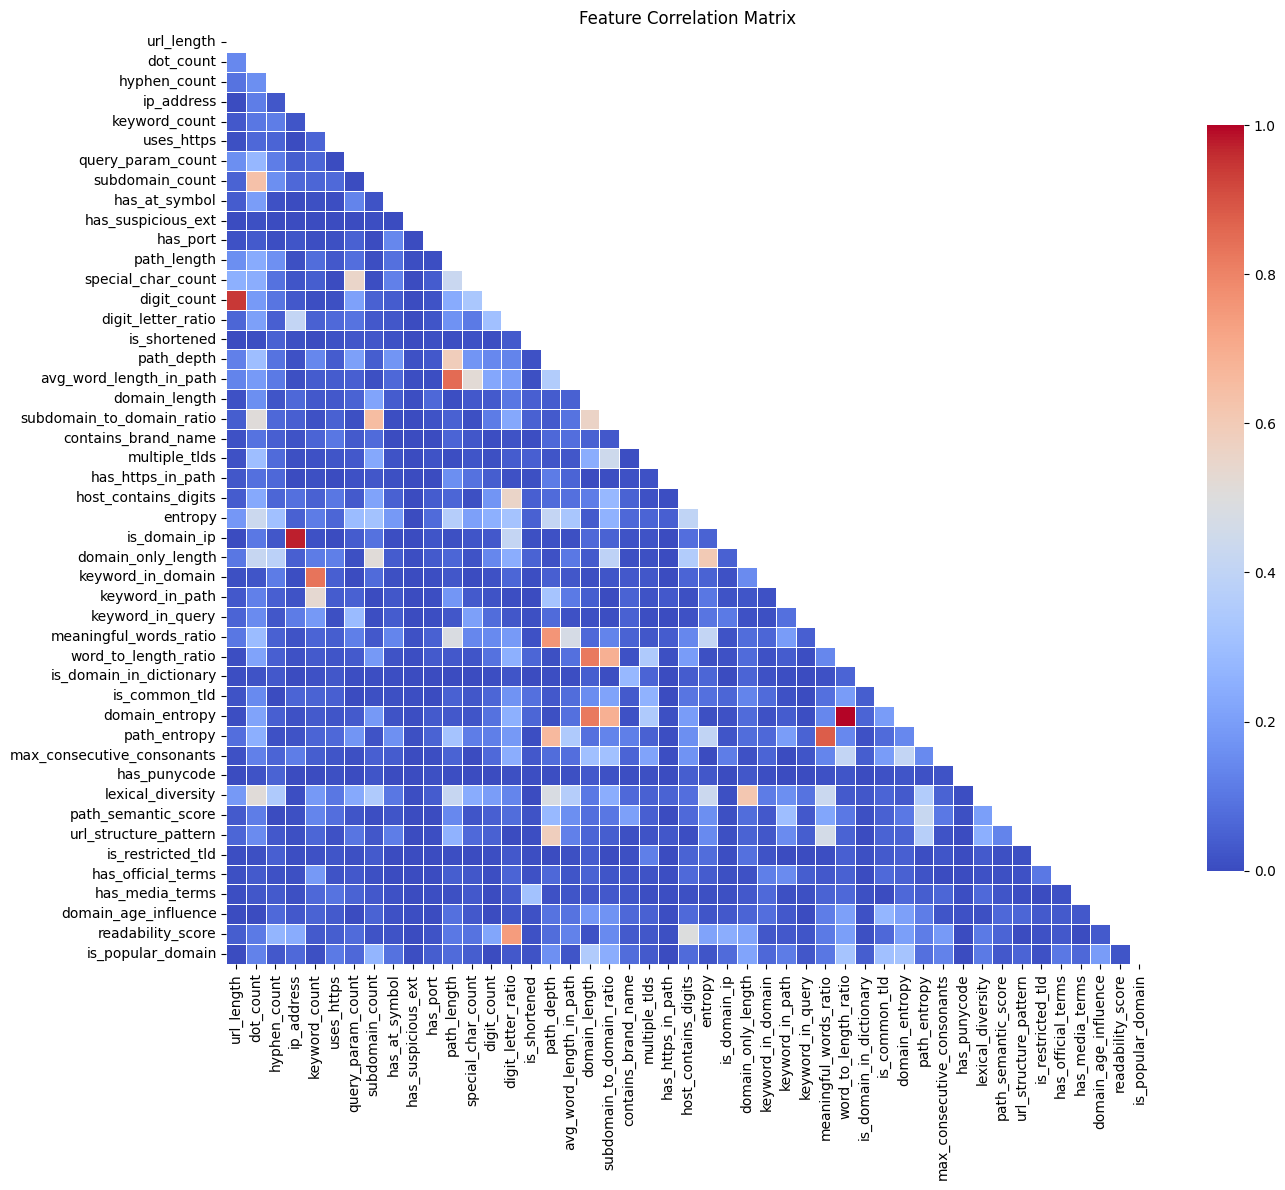

In [5]:
print("[+] Performing feature selection...")
# Initialize feature selector with correlation threshold of 0.8
feature_selector = FeatureSelector(correlation_threshold=0.8, feature_names=all_feature_names)

# Fit feature selector to data
feature_selector.fit(X_df)

# Generate correlation matrix plot
feature_selector.plot_correlation_matrix(output_path=f'{training_report_dir}/feature_correlation_matrix.png')
plt.figure(figsize=(12, 10))
feature_selector.plot_correlation_matrix()
plt.title('Feature Correlation Matrix')
plt.show()

Feature importance plot saved to training_report/feature_importance_analysis.png


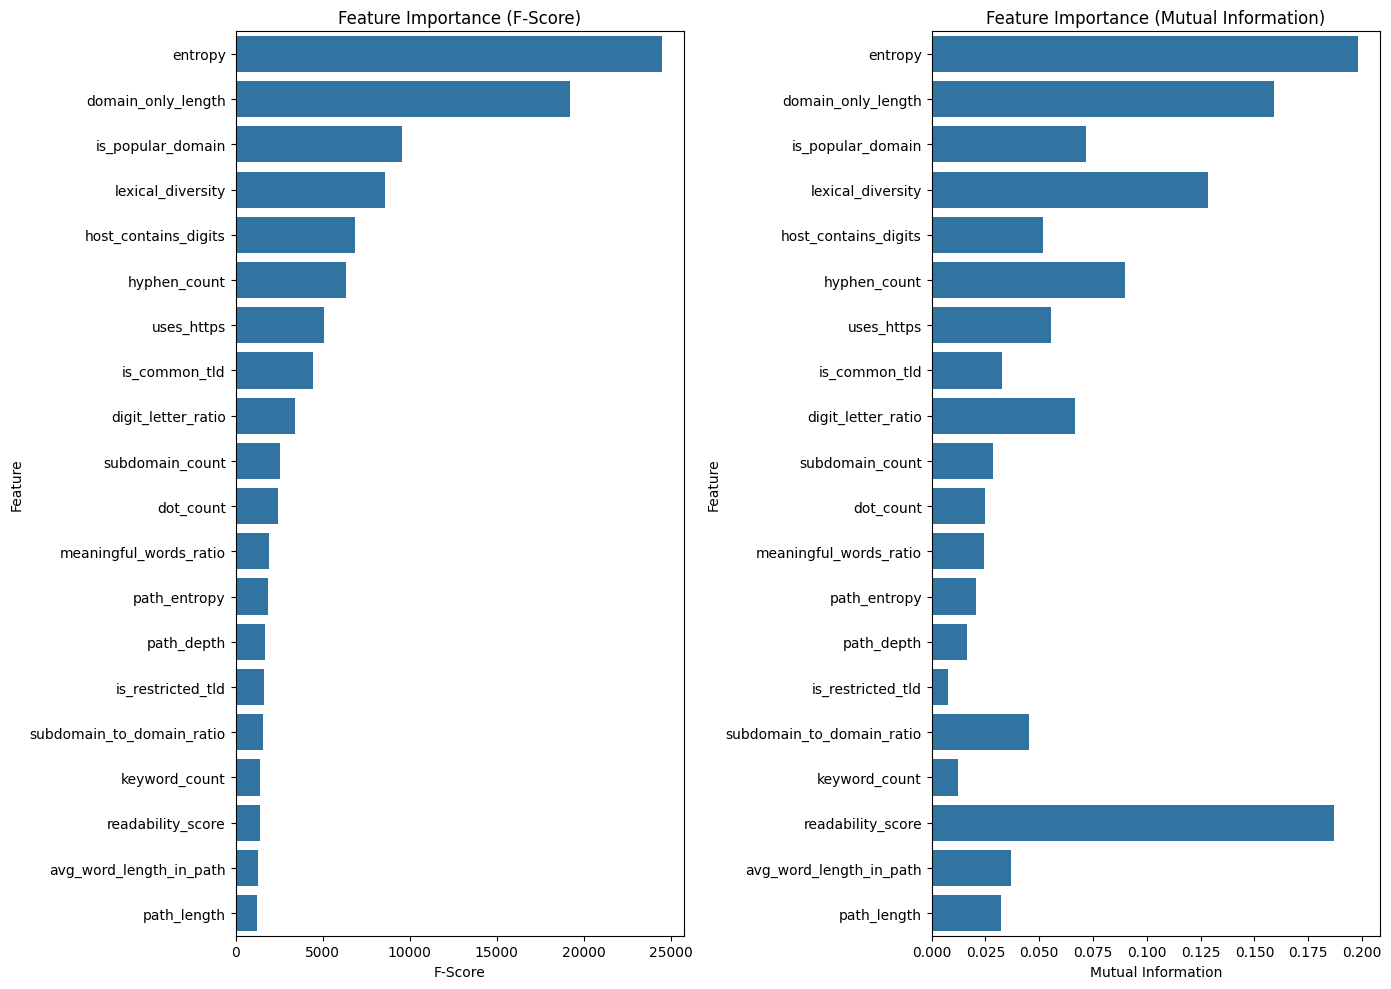

In [6]:
# Generate feature importance plots
# Store the importance dataframe
importance_df = feature_selector.plot_feature_importance(X_df, y, output_path=f'{training_report_dir}/feature_importance_analysis.png')

# Create a new figure for display in notebook
plt.figure(figsize=(14, 10))

# Plot F-Score importance
plt.subplot(1, 2, 1)
sns.barplot(y='Feature', x='F-Score', data=importance_df)
plt.title('Feature Importance (F-Score)')

# Plot Mutual Information importance
plt.subplot(1, 2, 2)
sns.barplot(y='Feature', x='Mutual Information', data=importance_df)
plt.title('Feature Importance (Mutual Information)')

plt.tight_layout()
plt.show()

In [7]:
# Get selected features after correlation analysis
selected_features = feature_selector.get_selected_features()
print(f"[+] Selected {len(selected_features)} features out of {X_df.shape[1]} after correlation analysis")
print("\nSelected features:")
print(selected_features)

[+] Selected 40 features out of 47 after correlation analysis

Selected features:
['dot_count', 'hyphen_count', 'keyword_count', 'uses_https', 'query_param_count', 'subdomain_count', 'has_at_symbol', 'has_suspicious_ext', 'has_port', 'path_length', 'special_char_count', 'digit_count', 'digit_letter_ratio', 'is_shortened', 'path_depth', 'subdomain_to_domain_ratio', 'contains_brand_name', 'multiple_tlds', 'has_https_in_path', 'host_contains_digits', 'entropy', 'is_domain_ip', 'domain_only_length', 'keyword_in_path', 'keyword_in_query', 'meaningful_words_ratio', 'word_to_length_ratio', 'is_domain_in_dictionary', 'is_common_tld', 'max_consecutive_consonants', 'has_punycode', 'lexical_diversity', 'path_semantic_score', 'url_structure_pattern', 'is_restricted_tld', 'has_official_terms', 'has_media_terms', 'domain_age_influence', 'readability_score', 'is_popular_domain']


In [8]:
# Additional feature selection using RFE (more aggressive selection)
rfe_features = feature_selector.select_features_with_rfe(X_df, y, n_features=min(30, len(selected_features)))
print(f"[+] Selected {len(rfe_features)} features using Recursive Feature Elimination")
print("\nRFE selected features:")
print(rfe_features)

[+] Selected 30 features using Recursive Feature Elimination

RFE selected features:
['ip_address', 'keyword_count', 'uses_https', 'subdomain_count', 'has_at_symbol', 'digit_letter_ratio', 'domain_length', 'subdomain_to_domain_ratio', 'contains_brand_name', 'multiple_tlds', 'has_https_in_path', 'host_contains_digits', 'entropy', 'domain_only_length', 'keyword_in_domain', 'keyword_in_path', 'keyword_in_query', 'meaningful_words_ratio', 'is_domain_in_dictionary', 'is_common_tld', 'domain_entropy', 'path_entropy', 'has_punycode', 'lexical_diversity', 'path_semantic_score', 'url_structure_pattern', 'is_restricted_tld', 'has_official_terms', 'has_media_terms', 'is_popular_domain']


In [9]:
# Print feature selection information
dropped_info = feature_selector.get_dropped_features_info()
if dropped_info:
    print("\n[+] Dropped features due to high correlation:")
    for dropped, kept, corr in dropped_info:
        print(f"    - Dropped '{dropped}' (kept '{kept}', correlation: {corr:.3f})")


[+] Dropped features due to high correlation:
    - Dropped 'domain_entropy' (kept 'word_to_length_ratio', correlation: 1.000)
    - Dropped 'ip_address' (kept 'is_domain_ip', correlation: 0.976)
    - Dropped 'url_length' (kept 'digit_count', correlation: 0.942)
    - Dropped 'path_entropy' (kept 'meaningful_words_ratio', correlation: 0.881)
    - Dropped 'avg_word_length_in_path' (kept 'path_length', correlation: 0.853)
    - Dropped 'keyword_in_domain' (kept 'keyword_count', correlation: 0.834)
    - Dropped 'domain_length' (kept 'word_to_length_ratio', correlation: 0.822)


In [10]:
# Extract the selected features only
X_selected = X_df[rfe_features]

## 6. Train/Test Split

In [11]:
print("[+] Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

[+] Splitting data into training and test sets...
Training set: 70419 samples
Test set: 17605 samples


## 7. Model Training and Hyperparameter Tuning

We'll train a LinearSVC model with hyperparameter tuning.

In [12]:
# --- Define Models with Hyperparameter Tuning ---
print("[+] Setting up LinearSVC model for hyperparameter tuning...")
# Only use LinearSVC model
model = LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)

# Define hyperparameter grid for LinearSVC
param_grid = {'C': [0.1, 1.0, 10.0]}

# Hyperparameter tuning with cross-validation
print("[+] Training and tuning LinearSVC...")
grid_search = GridSearchCV(
    model, param_grid, cv=3, scoring='f1', n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

[+] Setting up LinearSVC model for hyperparameter tuning...
[+] Training and tuning LinearSVC...
Best parameters: {'C': 0.1}
Best cross-validation score: 0.9819


## 8. Model Evaluation

In [13]:
# Evaluate on test set
print("[+] Evaluating LinearSVC on test set...")
y_pred = best_model.predict(X_test)

# For probabilistic predictions (if applicable)
if hasattr(best_model, "decision_function"):
    y_score = best_model.decision_function(X_test)
else:
    y_score = y_pred

[+] Evaluating LinearSVC on test set...


In [14]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9728
Precision: 0.9900
Recall: 0.9755
F1 Score: 0.9827


In [15]:
# Detailed classification report
report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     0.9118    0.9623    0.9364      3662
           1     0.9900    0.9755    0.9827     13943

    accuracy                         0.9728     17605
   macro avg     0.9509    0.9689    0.9595     17605
weighted avg     0.9737    0.9728    0.9731     17605



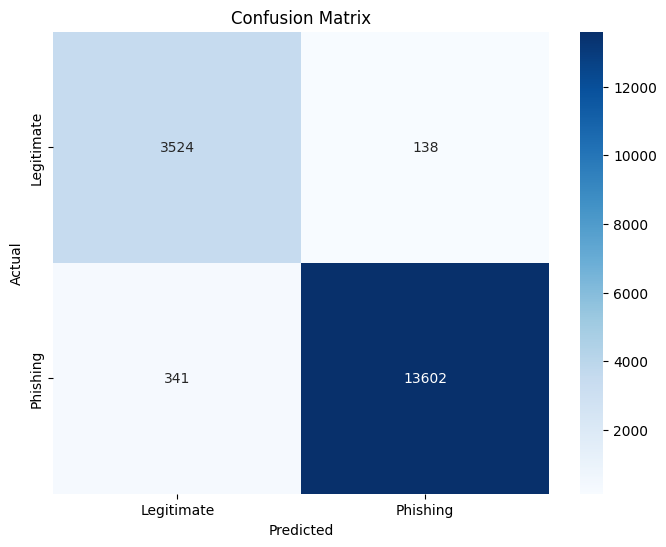

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Legitimate', 'Phishing'],
           yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'{training_report_dir}/LinearSVC_confusion_matrix.png')
plt.show()

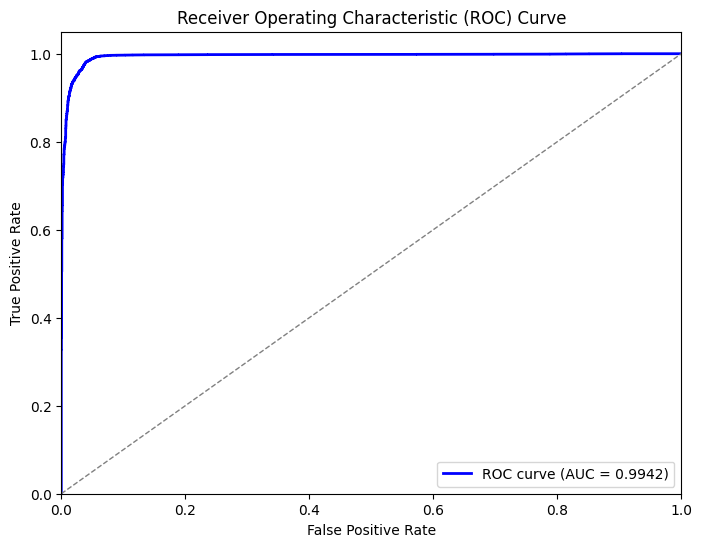

ROC AUC: 0.9942


In [17]:
# Try to calculate ROC AUC
try:
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig(f'{training_report_dir}/roc_curve.png')
    plt.show()
    print(f"ROC AUC: {roc_auc:.4f}")
except Exception as e:
    print(f"Could not calculate ROC AUC: {e}")

## 9. Feature Importance Analysis

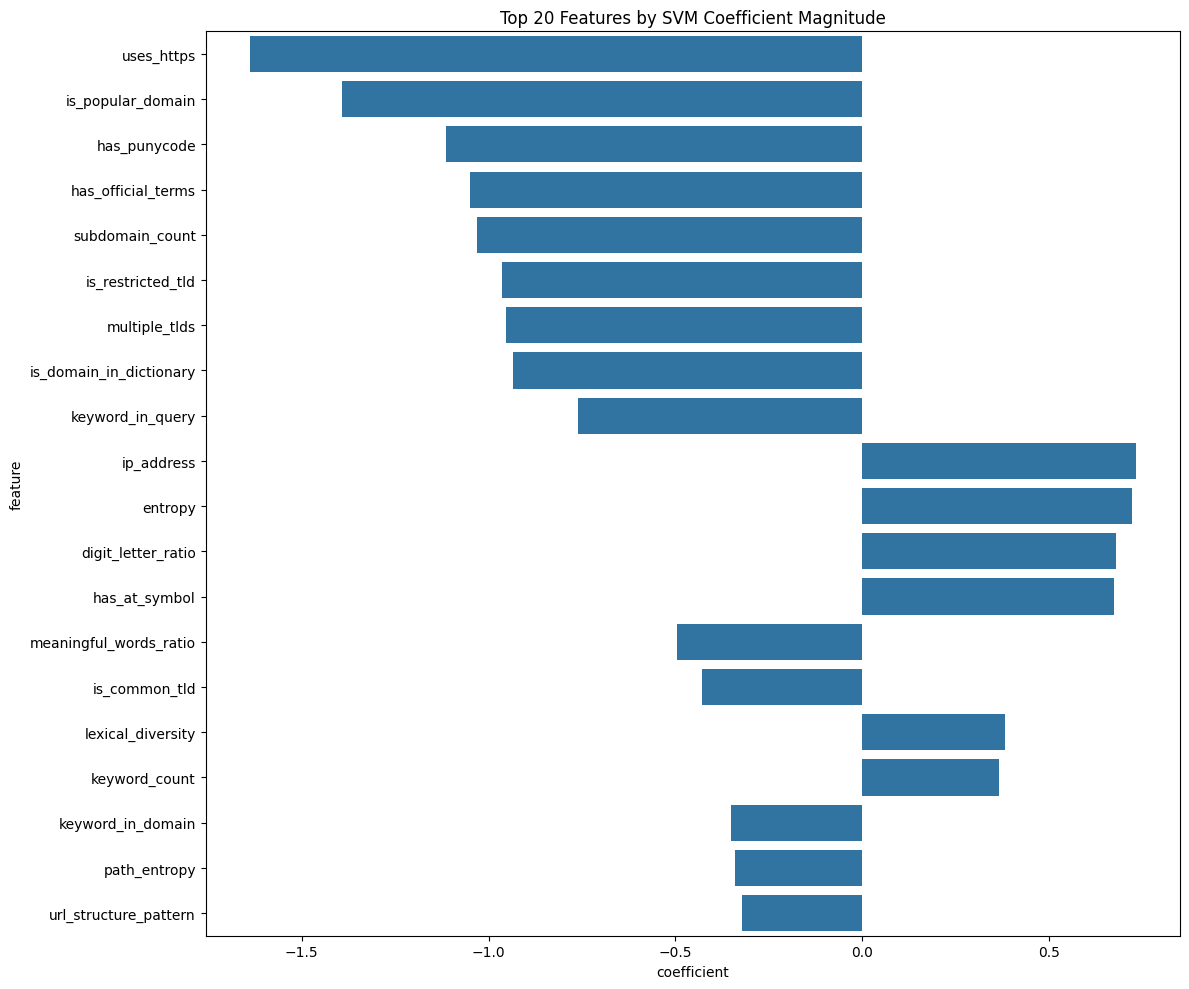

Top 10 most important features:
                    feature  coefficient
2                uses_https    -1.638085
29        is_popular_domain    -1.391540
22             has_punycode    -1.112768
27       has_official_terms    -1.050226
3           subdomain_count    -1.029846
26        is_restricted_tld    -0.963370
9             multiple_tlds    -0.954059
18  is_domain_in_dictionary    -0.935013
16         keyword_in_query    -0.759776
0                ip_address     0.730949


In [18]:
# Extract feature importance from SVM coefficients
if hasattr(best_model, 'coef_'):
    coef = best_model.coef_[0]
    # Create a DataFrame with feature names and their coefficients
    feature_importance_df = pd.DataFrame({
        'feature': rfe_features,
        'coefficient': coef
    })
    
    # Sort by absolute value of coefficient
    feature_importance_df['abs_coef'] = feature_importance_df['coefficient'].abs()
    feature_importance_df = feature_importance_df.sort_values('abs_coef', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    sns.barplot(x='coefficient', y='feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Features by SVM Coefficient Magnitude')
    plt.tight_layout()
    plt.savefig(f'{training_report_dir}/svc_coefficient_plot.png')
    plt.show()
    
    # Save feature importance to CSV and JSON
    feature_importance_df.to_csv(f'{models_dir}/svc_feature_importance.csv', index=False)
    feature_importance_df.to_json(f'{models_dir}/svc_feature_importance.json', orient='records')
    
    print("Top 10 most important features:")
    print(feature_importance_df[['feature', 'coefficient']].head(10))

## 10. Save Model and Features

In [19]:
# Save the model and feature information
print("[+] Saving model and feature information...")
dump(best_model, f'{models_dir}/svm_model.joblib')
dump(custom_extractor, f'{models_dir}/custom_extractor.joblib')
dump(feature_selector, f'{models_dir}/feature_selector.joblib')

# Save selected features
selected_features_dict = {
    'correlation_selected': selected_features,
    'rfe_selected': rfe_features
}
with open(f'{models_dir}/selected_features.json', 'w') as f:
    json.dump(selected_features_dict, f)

print("[+] Model and features saved successfully!")

[+] Saving model and feature information...
[+] Model and features saved successfully!


## 11. Inference Example

Let's test our model with a few example URLs:

In [20]:
# Function to predict if a URL is phishing
def predict_url(url, model, extractor, selected_features):
    # Extract features
    features = extractor.transform([url])
    # Convert to DataFrame
    features_df = pd.DataFrame(features, columns=all_feature_names[:features.shape[1]])
    # Select the relevant features
    features_selected = features_df[selected_features]
    # Make prediction
    prediction = model.predict(features_selected)[0]
    # Get confidence score if available
    if hasattr(model, 'decision_function'):
        confidence = model.decision_function(features_selected)[0]
    else:
        confidence = None
    
    result = "Phishing" if prediction == 1 else "Legitimate"
    return result, prediction, confidence

In [21]:
# Test URLs
test_urls = [
    "https://google.com",
    "https://facebook.com/login",
    "http://g00gle.com/login.php",
    "http://secure-paypal.com.randomdomain.com/login",
    "https://apple.com/icloud/login",
    "https://appleid.apple.com.phishing-domain.com/signin"
]

# Make predictions
print("URL Predictions:")
print("-" * 80)
for url in test_urls:
    result, pred, conf = predict_url(url, best_model, custom_extractor, rfe_features)
    print(f"URL: {url}")
    print(f"Prediction: {result} (class {pred})")
    if conf is not None:
        print(f"Confidence score: {conf:.4f}")
    print("-" * 80)

URL Predictions:
--------------------------------------------------------------------------------
URL: https://google.com
Prediction: Legitimate (class 0)
Confidence score: -2.1070
--------------------------------------------------------------------------------
URL: https://facebook.com/login
Prediction: Legitimate (class 0)
Confidence score: -1.4440
--------------------------------------------------------------------------------
URL: http://g00gle.com/login.php
Prediction: Phishing (class 1)
Confidence score: 2.7262
--------------------------------------------------------------------------------
URL: http://secure-paypal.com.randomdomain.com/login
Prediction: Phishing (class 1)
Confidence score: 6.5435
--------------------------------------------------------------------------------
URL: https://apple.com/icloud/login
Prediction: Legitimate (class 0)
Confidence score: -1.3902
--------------------------------------------------------------------------------
URL: https://appleid.apple.com

## 12. Export Model for Extension

We can export the model for use in a browser extension:

In [22]:
# Export constants from the feature extractor
from constants import (
    COMMON_TLDS,
    RESTRICTED_CCTLDS,
    OFFICIAL_TERMS,
    MEDIA_TERMS,
    DICTIONARY_WORDS,
    SUSPICIOUS_KEYWORDS,
    SUSPICIOUS_EXTENSIONS,
    URL_SHORTENERS,
    COMMON_PATTERNS,
    LANGUAGE_CODES,
    CONTENT_INDICATORS,
    BRAND_NAMES,
    POPULAR_DOMAINS
)

# Custom JSON encoder to handle numpy types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# Export model data
model_data = {
    'intercept': best_model.intercept_[0],
    'coefficients': best_model.coef_[0].tolist(),
    'classes': best_model.classes_.tolist(),
    'feature_names': rfe_features,
    'constants': {
        'commonTlds': list(COMMON_TLDS),
        'restrictedTlds': list(RESTRICTED_CCTLDS),
        'officialTerms': list(OFFICIAL_TERMS),
        'mediaTerms': list(MEDIA_TERMS),
        'suspiciousKeywords': list(SUSPICIOUS_KEYWORDS),
        'suspiciousExtensions': list(SUSPICIOUS_EXTENSIONS),
        'urlShorteners': list(URL_SHORTENERS),
        'brandNames': list(BRAND_NAMES),
        'commonPatterns': list(COMMON_PATTERNS),
        'languageCodes': list(LANGUAGE_CODES),
        'contentIndicators': list(CONTENT_INDICATORS),
        'popularDomains': list(POPULAR_DOMAINS)
    }
}

# Save model metadata as JSON for extension
extension_output_path = '../phishing-detector-extension/model_metadata.json'
local_output_path = './model_metadata.json'

with open(extension_output_path, 'w') as f:
    json.dump(model_data, f, cls=NumpyEncoder, indent=4)

print(f"[+] Model metadata exported to {extension_output_path}")

[+] Model metadata exported to ../phishing-detector-extension/model_metadata.json


## 13. Conclusion

We've successfully built a phishing URL detection model based on static URL features. The LinearSVC model demonstrated strong performance in distinguishing between phishing and legitimate URLs. The model can be integrated into browser extensions, security systems, or used for batch processing of URL datasets.